In [81]:
import types
import numpy as np
import pandas as pd
import numpy.dual as dual
from imblearn.over_sampling import SMOTE, SMOTENC

from sklearn import metrics as sk_metrics
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier, CatBoostRegressor, Pool

In [2]:
def load_data():
    pd_data_1 = pd.read_csv("equipment_failure_data_1.csv", sep=",", header=0)
    pd_data_2 = pd.read_csv("equipment_failure_data_2.csv", sep=",", header=0)
    return pd.concat([pd_data_1, pd_data_2])

pd_data = load_data()
pd_data.head()

,ID,DATE,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,S5,S16,S19,S18,EQUIPMENT_FAILURE,S8,AGE_OF_EQUIPMENT
0,100001,12/2/14,G,O,Y,1,11.088000,145.223448,39.34,3501.0,8.426869,1.9,24.610345,0,0.0,880
1,100001,12/3/14,G,O,Y,1,8.877943,187.573214,39.20,3489.0,6.483714,1.9,24.671429,0,0.0,881
2,100001,12/4/14,G,O,Y,1,8.676444,148.363704,38.87,3459.0,6.159659,2.0,24.733333,0,0.0,882
3,100001,12/5/14,G,O,Y,1,9.988338,133.660000,39.47,3513.0,9.320308,2.0,24.773077,0,0.0,883
4,100001,12/6/14,G,O,Y,1,8.475264,197.181600,40.33,3589.0,8.022960,1.5,24.808000,0,0.0,884


# EDA

In [3]:
pd_data.shape 

(307751, 16)

In [4]:
# unique device IDs
pd.DataFrame(pd_data.groupby(['ID']).agg(['count'])).shape

(421, 15)

In [5]:
# unique dates
pd.DataFrame(pd_data.groupby(['DATE']).agg(['count'])).shape

(731, 15)

In [6]:
# drop duplicates
df_failure_thingy=pd_data
df_failure_thingy=df_failure_thingy.drop_duplicates(subset=['ID','DATE'])
df_failure_thingy.shape # same shape - no duplicates were there

(307751, 16)

In [7]:
# no nulls
pd_data.isnull().sum(axis = 0)

ID                    0
DATE                  0
REGION_CLUSTER        0
MAINTENANCE_VENDOR    0
MANUFACTURER          0
WELL_GROUP            0
S15                   0
S17                   0
S13                   0
S5                    0
S16                   0
S19                   0
S18                   0
EQUIPMENT_FAILURE     0
S8                    0
AGE_OF_EQUIPMENT      0
dtype: int64

In [8]:
# each device has failed single time
pd.DataFrame(pd_data.groupby(['EQUIPMENT_FAILURE'])['ID'].agg('count'))

,ID
EQUIPMENT_FAILURE,
0,307330
1,421


In [9]:
pd_data.describe()

,ID,WELL_GROUP,S15,S17,S13,S5,S16,S19,S18,EQUIPMENT_FAILURE,S8,AGE_OF_EQUIPMENT
count,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000
mean,100310.826603,4.543943,14.585192,80.265541,35.018249,4675.848252,7.972097,9.069123,137.963064,0.001368,144.665715,2524.192399
std,177.574390,2.284121,8.817056,85.804273,14.446585,2521.074632,2.321949,16.898887,238.890128,0.036961,240.773926,3158.930976
min,100001.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-16.490000,0.000000
25%,100161.000000,3.000000,7.694100,0.000000,28.200000,3209.000000,6.621500,0.900000,11.798276,0.000000,9.250000,721.000000
50%,100311.000000,5.000000,11.661600,31.680000,34.940000,4237.047619,8.004000,4.200000,38.200000,0.000000,53.080000,1113.000000
75%,100467.000000,6.000000,22.560000,160.080000,41.610000,5743.000000,9.460000,10.600000,150.900000,0.000000,165.092608,2784.000000
max,100617.000000,8.000000,59.040000,2555.520000,592.890000,52767.000000,24.600000,511.000000,4151.700000,1.000000,2068.110000,15170.000000


In [10]:
# correlations 1

xxx=pd_data.corr( method='pearson')
xxx=xxx[['EQUIPMENT_FAILURE']]
xxx['ABS_EQUIPMENT_FAILURE']=abs(xxx['EQUIPMENT_FAILURE'])
xxx=xxx.sort_values(by=['ABS_EQUIPMENT_FAILURE'], ascending=[False])
xxx

,EQUIPMENT_FAILURE,ABS_EQUIPMENT_FAILURE
EQUIPMENT_FAILURE,1.000000e+00,1.000000e+00
S15,-6.036352e-02,6.036352e-02
S17,-3.429070e-02,3.429070e-02
S18,9.765002e-03,9.765002e-03
S13,-8.617761e-03,8.617761e-03
S5,-7.189979e-03,7.189979e-03
S8,6.517148e-03,6.517148e-03
S16,-6.138895e-03,6.138895e-03
S19,-6.087474e-03,6.087474e-03
AGE_OF_EQUIPMENT,4.733368e-04,4.733368e-04


In [11]:
# correlations 2

pd_data.corr(method='pearson').style.background_gradient(cmap='coolwarm', axis=None)

,ID,WELL_GROUP,S15,S17,S13,S5,S16,S19,S18,EQUIPMENT_FAILURE,S8,AGE_OF_EQUIPMENT
ID,1.000000,-0.037441,-0.035295,0.026763,-0.037786,0.009999,0.053049,-0.040664,0.036977,0.000000,0.037107,0.021574
WELL_GROUP,-0.037441,1.000000,0.049638,-0.065829,-0.069329,0.007193,0.014661,0.067174,0.091050,0.000000,0.089935,-0.059788
S15,-0.035295,0.049638,1.000000,-0.610341,0.071915,0.261755,-0.113802,0.175694,0.380411,-0.060364,0.330548,0.024427
S17,0.026763,-0.065829,-0.610341,1.000000,0.117863,-0.150205,0.167563,-0.153561,-0.409661,-0.034291,-0.334659,-0.019681
S13,-0.037786,-0.069329,0.071915,0.117863,1.000000,0.422768,0.087766,-0.039499,-0.083504,-0.008618,-0.048435,0.033191
S5,0.009999,0.007193,0.261755,-0.150205,0.422768,1.000000,-0.109097,0.269741,0.535484,-0.007190,0.562171,0.034668
S16,0.053049,0.014661,-0.113802,0.167563,0.087766,-0.109097,1.000000,-0.126645,-0.044546,-0.006139,-0.022518,0.018336
S19,-0.040664,0.067174,0.175694,-0.153561,-0.039499,0.269741,-0.126645,1.000000,0.230667,-0.006087,0.186710,-0.026847
S18,0.036977,0.091050,0.380411,-0.409661,-0.083504,0.535484,-0.044546,0.230667,1.000000,0.009765,0.856692,-0.027915
EQUIPMENT_FAILURE,0.000000,0.000000,-0.060364,-0.034291,-0.008618,-0.007190,-0.006139,-0.006087,0.009765,1.000000,0.006517,0.000473


Nothing is straightly correlated with Equipment_failure

# Prepare Data

In [12]:
def prepear_data(pd_data, feature_window, target_window):
    pd_data['DATE'] = pd.to_datetime(pd_data['DATE'])

    # to see, where id changes in dataframe
    pd_data=pd_data.sort_values(by=['ID','DATE'], ascending=[True, True])
    pd_data['flipper'] = np.where((pd_data.ID != pd_data.ID.shift(1)), 1, 0)
    
    # here we will use meaned data for some windows
    dfx = pd_data

    # get first rows with start dates
    starter = pd_data[pd_data['flipper'] == 1][['DATE','ID']]
    starter = starter.rename(index=str, columns={"DATE": "START_DATE"})
    starter['START_DATE'] = pd.to_datetime(starter['START_DATE'])

    # merge START_DATE to the original data set
    pd_data = pd_data.sort_values(by=['ID', 'DATE'], ascending=[True, True])
    starter = starter.sort_values(by=['ID'], ascending=[True])
    pd_data = pd_data.merge(starter, on=['ID'], how='left')

    # calculate the number of days since the beginning of each deploy.
    pd_data['C'] = pd_data['DATE'] - pd_data['START_DATE']
    pd_data['TIME_SINCE_START'] = pd_data['C'] / np.timedelta64(1, 'D')
    pd_data=pd_data.drop(columns=['C'])
    pd_data['too_soon'] = np.where((pd_data.TIME_SINCE_START < feature_window) , 1, 0)

    # make windows mean, median, max, min. if there are less than window size numbers - place the sensor value as it is
    for ftr in ['S5', 'S13', 'S15', 'S16', 'S17', 'S18', 'S19']:
        pd_data[f'{ftr}_mean'] = np.where((pd_data.too_soon == 0),(pd_data[ftr].rolling(min_periods=1, window=feature_window).mean()) , pd_data[ftr])
        pd_data[f'{ftr}_median'] = np.where((pd_data.too_soon == 0),(pd_data[ftr].rolling(min_periods=1, window=feature_window).median()) , pd_data[ftr])
        pd_data[f'{ftr}_max'] = np.where((pd_data.too_soon == 0),(pd_data[ftr].rolling(min_periods=1, window=feature_window).max()) , pd_data[ftr])
        pd_data[f'{ftr}_min'] = np.where((pd_data.too_soon == 0),(pd_data[ftr].rolling(min_periods=1, window=feature_window).min()) , pd_data[ftr])

        pd_data[f'{ftr}_chg'] = np.where((pd_data[f'{ftr}_mean'] == 0), 0, pd_data[ftr]/pd_data[f'{ftr}_mean'])    
    
    
    # put targets in target_window before failure
    pd_data=pd_data.sort_values(by=['ID', 'DATE'], ascending=[True, True])
    pd_data.reset_index(level=0, inplace=True)

    # get failure dates
    df_failure_thingy=pd_data[pd_data['EQUIPMENT_FAILURE'] == 1]
    df_failure_thingy=df_failure_thingy[['DATE','ID']]
    df_failure_thingy=df_failure_thingy.rename(index=str, columns={"DATE": "FAILURE_DATE"})
    df_failure_thingy=df_failure_thingy.sort_values(by=['ID'], ascending=[True])

    pd_data=pd_data.merge(df_failure_thingy, on=['ID'], how='left') # in case if some devices have never failed - left
    # pd_data=pd_data.sort_values(by=['ID','DATE'], ascending=[True, True])
    pd_data['FAILURE_DATE'] = pd.to_datetime(pd_data['FAILURE_DATE'])
    pd_data['DATE'] = pd.to_datetime(pd_data['DATE'])
    pd_data['C'] = pd_data['FAILURE_DATE'] - pd_data['DATE']
    pd_data['TIME_TO_FAILURE'] = pd_data['C'] / np.timedelta64(1, 'D')
    pd_data=pd_data.drop(columns=['C'])
    pd_data=pd_data.drop(columns=['index'])

    pd_data=pd_data.sort_values(by=['ID', 'DATE'], ascending=[True, True])
    pd_data.reset_index(inplace=True)
    pd_data['FAILURE_TARGET'] = np.where(((pd_data.TIME_TO_FAILURE < target_window) & ((pd_data.TIME_TO_FAILURE>=0))), 1, 0)
    
    return pd_data
        
    
feature_window = 21
target_window = 28
pd_data = prepear_data(load_data(), feature_window, target_window)
pd_data.head()

,index,ID,DATE,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,...,S18_min,S18_chg,S19_mean,S19_median,S19_max,S19_min,S19_chg,FAILURE_DATE,TIME_TO_FAILURE,FAILURE_TARGET
0,0,100001,2014-12-02,G,O,Y,1,11.088000,145.223448,39.34,...,24.610345,1.0,1.9,1.9,1.9,1.9,1.0,2015-04-24,143.0,0
1,1,100001,2014-12-03,G,O,Y,1,8.877943,187.573214,39.20,...,24.671429,1.0,1.9,1.9,1.9,1.9,1.0,2015-04-24,142.0,0
2,2,100001,2014-12-04,G,O,Y,1,8.676444,148.363704,38.87,...,24.733333,1.0,2.0,2.0,2.0,2.0,1.0,2015-04-24,141.0,0
3,3,100001,2014-12-05,G,O,Y,1,9.988338,133.660000,39.47,...,24.773077,1.0,2.0,2.0,2.0,2.0,1.0,2015-04-24,140.0,0
4,4,100001,2014-12-06,G,O,Y,1,8.475264,197.181600,40.33,...,24.808000,1.0,1.5,1.5,1.5,1.5,1.0,2015-04-24,139.0,0


# Train-Valid-Test data split

In [13]:
train_fraction = 0.35
valid_fraction = 0.3
test_fraction = 1 - train_fraction - valid_fraction
assert test_fraction > 0

pd_id = pd_data.drop_duplicates(subset='ID')[['ID']]

np.random.seed(42)
pd_id['wookie'] = (np.random.randint(0, 10000, pd_id.shape[0]))/10000
pd_id['MODELING_GROUP'] = np.where(((pd_id.wookie <= train_fraction)), 'TRAINING', np.where(((pd_id.wookie <= train_fraction+valid_fraction)), 'VALIDATION', 'TESTING'))
pd_data = pd_data.sort_values(by=['ID'], ascending=[True])
pd_id = pd_id.sort_values(by=['ID'], ascending=[True])
pd_data = pd_data.merge(pd_id, on=['ID'], how='inner')

In [14]:
pd_data.groupby(['MODELING_GROUP'])['wookie'].count()

MODELING_GROUP
TESTING       108919
TRAINING      106726
VALIDATION     92106
Name: wookie, dtype: int64

In [15]:
pd_data.groupby(['MODELING_GROUP'])['FAILURE_TARGET'].sum()

MODELING_GROUP
TESTING       4151
TRAINING      4071
VALIDATION    3518
Name: FAILURE_TARGET, dtype: int64

In [16]:
features = ['REGION_CLUSTER','MAINTENANCE_VENDOR','MANUFACTURER','WELL_GROUP','AGE_OF_EQUIPMENT','S15','S17','S13','S5',
 'S16','S19','S18','S8','S5_mean','S5_median','S5_max','S5_min','S13_mean','S13_median','S13_max','S13_min','S15_mean','S15_median',
 'S15_max','S15_min','S16_mean','S16_median','S16_max','S16_min','S17_mean','S17_median','S17_max','S17_min','S18_mean','S18_median','S18_max','S18_min','S19_mean','S19_median','S19_max','S19_min',
 'S5_chg','S13_chg','S15_chg','S16_chg','S17_chg','S18_chg','S19_chg']

# predict a day in target window days before failure
target = 'FAILURE_TARGET'

df_train=pd_data[pd_data['MODELING_GROUP'] == 'TRAINING'][features+[target]].reset_index()
df_valid=pd_data[pd_data['MODELING_GROUP'] == 'VALIDATION'][features+[target]].reset_index()
df_test=pd_data[pd_data['MODELING_GROUP'] == 'TESTING'][features+[target]].reset_index()

# Dataset balancing

In [17]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC


def balance(df_original, features, target):
    #sm = SMOTE(random_state=12, ratio = 1.0)
    smx = SMOTENC(random_state=12,  categorical_features=[0, 1, 2, 3])
    x_res, y_res = smx.fit_sample(df_original[features], df_original[target].values.ravel())

    df_x=pd.DataFrame(x_res)
    df_x.columns = features

    df_y=pd.DataFrame(y_res)
    df_y.columns = [target]
    print(df_y.mean(axis = 0))
    
    return pd.concat([df_y, df_x], axis=1)

df_train_balanced = balance(df_train, features, target)

FAILURE_TARGET    0.5
dtype: float64


# Train the model

In [82]:
def cm_from_data(y_true, y_pred, title=''):
    data = {
        'y_true': y_true,
        'y_pred': y_pred
    }

    df = pd.DataFrame(data, columns=['y_true','y_pred'])
    confusion_matrix = pd.crosstab(df['y_true'], df['y_pred'], rownames=['Истинное значение'], colnames=['Предсказанное значение'])
    sns.heatmap(confusion_matrix, annot=True)
    plt.title(title)
    plt.show()
    plt.close()
    

def evaluate(model, df_x, df_y, mark='', printing=False, plot_cm=False):
    y_pred = model.predict(df_x)
    y_pred_proba = model.predict_proba(df_x)[:,1]
    acc = sk_metrics.accuracy_score(df_y, y_pred)
    recall = sk_metrics.recall_score(df_y, y_pred)
    f1 = sk_metrics.f1_score(df_y, y_pred)
    if printing:
        print(f"{mark} acc: {acc:.3f}")
        print(f"{mark} recall: {recall:.3f}")
        print(f"{mark} f1:{f1:.3f} ")
        print(f"{mark} roc: {metrics.roc_auc_score(df_y, y_pred_proba):.3f}")
    if plot_cm:
        cm_from_data(df_y, y_pred, mark)
        print()
    return {
        'acc': acc,
        'recall': recall,
        'f1': f1
    }

# Train on unbalanced

train acc: 0.999
train recall: 0.967
train f1:0.981 
train roc: 1.000


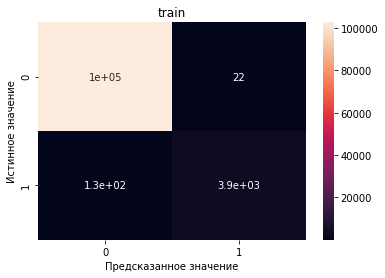


valid acc: 0.962
valid recall: 0.000
valid f1:0.000 
valid roc: 0.621


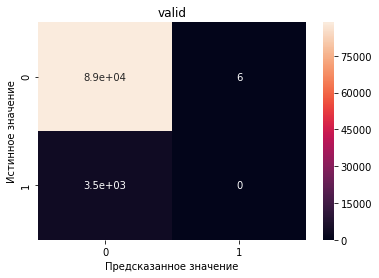


test acc: 0.962
test recall: 0.002
test f1:0.003 
test roc: 0.551


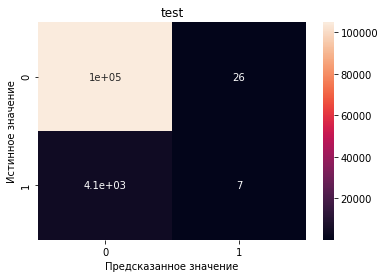

In [19]:
pool = Pool(
    df_train[features], 
    df_train[target],
    cat_features=['REGION_CLUSTER', 'MAINTENANCE_VENDOR', 'MANUFACTURER', 'WELL_GROUP']
)

unbalanced_model = CatBoostClassifier(
    verbose=False
)
unbalanced_model.fit(pool)
    
    
evaluate(unbalanced_model, df_train[features], df_train[target], 'train', plot_cm=True)
evaluate(unbalanced_model, df_valid[features], df_valid[target], 'valid', plot_cm=True)
evaluate(unbalanced_model, df_test[features], df_test[target], 'test', plot_cm=True)
print()

# Train on balanced

train acc: 0.999
train recall: 1.000
train f1:0.999 
train roc: 1.000


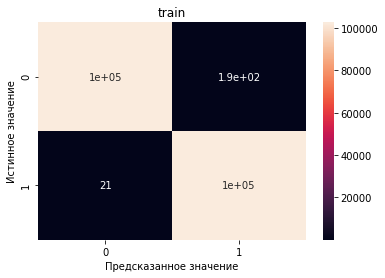


valid acc: 0.959
valid recall: 0.005
valid f1:0.009 
valid roc: 0.590


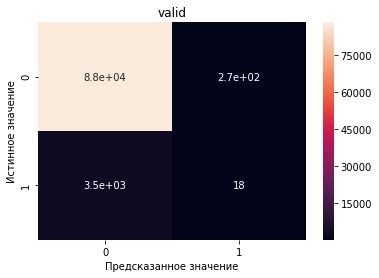


test acc: 0.957
test recall: 0.009
test f1:0.015 
test roc: 0.502


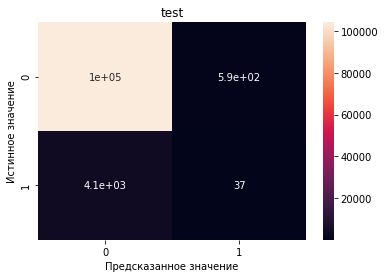

In [20]:
pool = Pool(
    df_train_balanced[features], 
    df_train_balanced[target],
    cat_features=['REGION_CLUSTER', 'MAINTENANCE_VENDOR', 'MANUFACTURER', 'WELL_GROUP']
)

balanced_model = CatBoostClassifier(
    verbose=False
)
balanced_model.fit(pool)
    
    
evaluate(balanced_model, df_train_balanced[features], df_train_balanced[target], 'train', plot_cm=True)
evaluate(balanced_model, df_valid[features], df_valid[target], 'valid', plot_cm=True)
evaluate(balanced_model, df_test[features], df_test[target], 'test', plot_cm=True)

# Feature importance

### Unbalanced

In [32]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(unbalanced_model)
shap_values = explainer.shap_values(df_train_balanced[features])

In [33]:
s_i = 100

shap.force_plot(explainer.expected_value, shap_values[s_i,:], df_train_balanced[features].iloc[s_i,:])

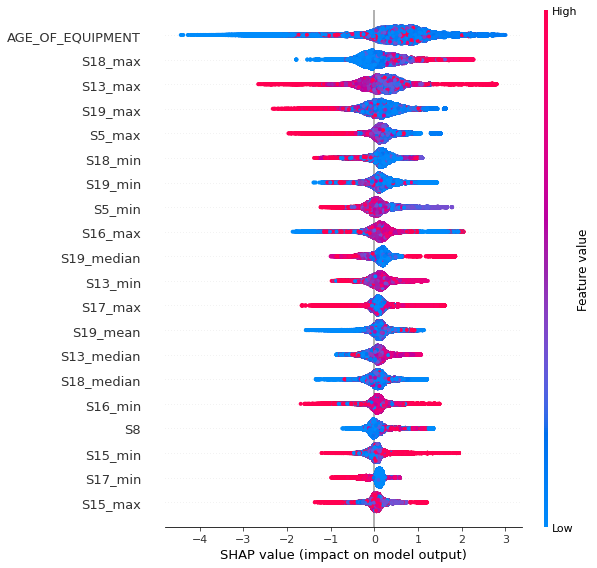

In [34]:
shap.summary_plot(shap_values, df_train_balanced[features])

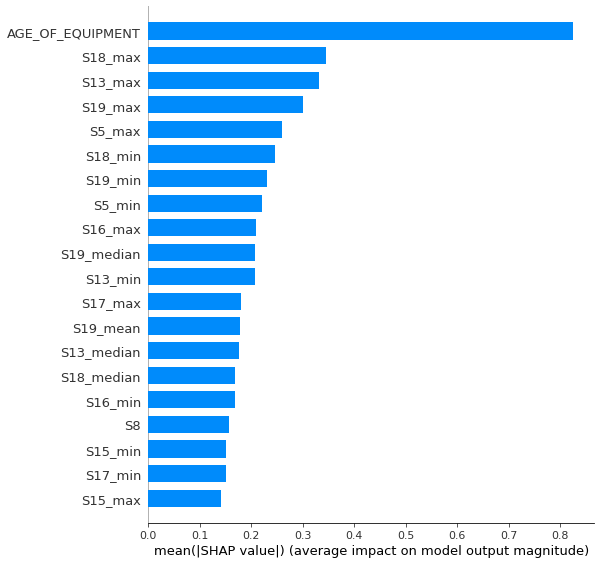

In [35]:
shap.summary_plot(shap_values, df_train_balanced[features], plot_type="bar")

### Balanced

In [36]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(balanced_model)
shap_values = explainer.shap_values(df_train_balanced[features])

In [37]:
s_i = 100

shap.force_plot(explainer.expected_value, shap_values[s_i,:], df_train_balanced[features].iloc[s_i,:])

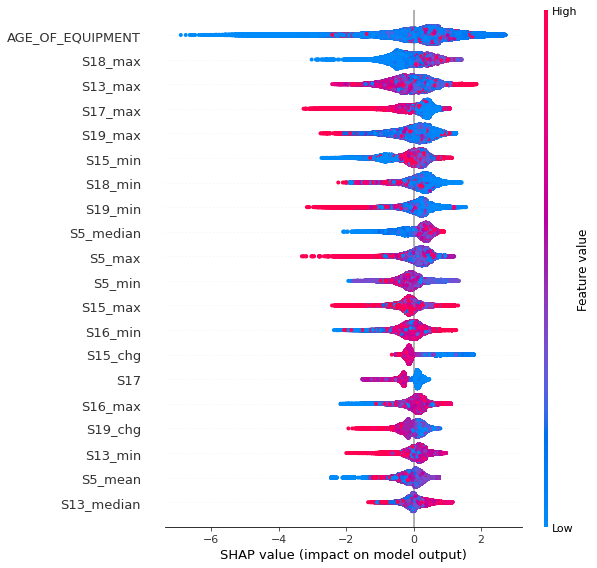

In [38]:
shap.summary_plot(shap_values, df_train_balanced[features])

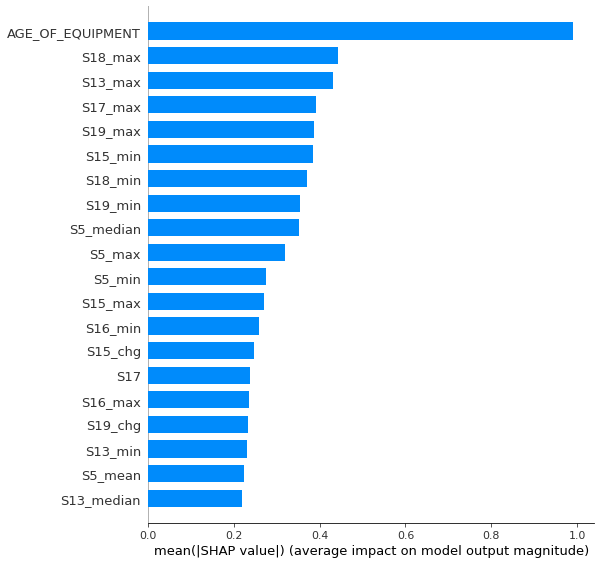

In [39]:
shap.summary_plot(shap_values, df_train_balanced[features], plot_type="bar")

# Ensemble

In [76]:
import tqdm
from random import randint

pool = Pool(
    df_train_balanced[features], 
    df_train_balanced[target],
    cat_features=['REGION_CLUSTER', 'MAINTENANCE_VENDOR', 'MANUFACTURER', 'WELL_GROUP']
)

models = []
for _ in tqdm.tqdm(range(12)):
    balanced_model = CatBoostClassifier(
        verbose=False,
        iterations = randint(30, 50),
        depth = randint(3, 6),
    )
    balanced_model.fit(pool)
    models.append(balanced_model)

100%|██████████| 12/12 [00:43<00:00,  3.64s/it]


In [83]:
train_metrics = []
valid_metrics = []
test_metrics = []

for i in tqdm.tqdm(range(len(models))):
    model = models[i]
    train_metrics.append(evaluate(model, df_train_balanced[features], df_train_balanced[target], 'train'))
    valid_metrics.append(evaluate(model, df_valid[features], df_valid[target], 'valid'))
    test_metrics.append(evaluate(model, df_test[features], df_test[target], 'test'))

100%|██████████| 12/12 [00:10<00:00,  1.13it/s]


In [84]:
for name, metrics in [
    ['train', train_metrics],
    ['valid', valid_metrics],
    ['test', test_metrics],
]:
    mean_metrics = {k: np.mean([m[k] for m in metrics])for k in metrics[0].keys()}
    for m in mean_metrics:
        print(name, m, mean_metrics[m])
    print()

train acc 0.8854971344146251
train recall 0.9342327861932364
train f1 0.8910574007372428

valid acc 0.8160733285562287
valid recall 0.29503032025772225
valid f1 0.1089077332454715

test acc 0.7808600886897604
test recall 0.2832048502368908
test f1 0.0881085959669899



regularization in action!

train acc: 0.885
train recall: 0.934
train f1:0.891 


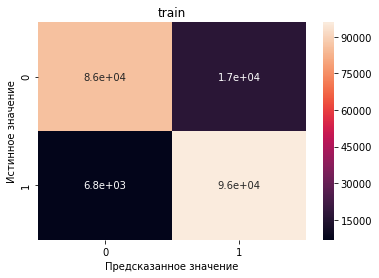


valid acc: 0.817
valid recall: 0.299
valid f1:0.111 


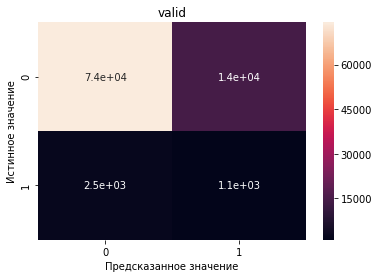


test acc: 0.781
test recall: 0.280
test f1:0.089 


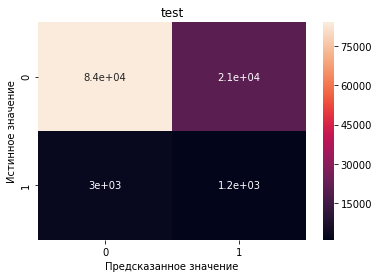

In [85]:
def evaluate_ensemble(models, x, y, mark='', plot_cm=False):
    predicts = []
    for model in models:
        predicts.append(model.predict(x))

#     predicts = np.round(np.mean(np.array(predicts), axis=0)).astype(np.int)
#     predicts = np.round(np.mean(, axis=0)+0.1).astype(np.int)
    predicts = np.array([np.random.choice(col) for col in np.array(predicts).T])

    print(f"{mark} acc: {sk_metrics.accuracy_score(y, predicts):.3f}")
    print(f"{mark} recall: {sk_metrics.recall_score(y, predicts):.3f}")
    print(f"{mark} f1:{sk_metrics.f1_score(y, predicts):.3f} ")
    if plot_cm:
        cm_from_data(y, predicts, mark)
    print()
    
evaluate_ensemble(models, df_train_balanced[features], df_train_balanced[target], 'train', plot_cm=True)
evaluate_ensemble(models, df_valid[features], df_valid[target], 'valid', plot_cm=True)
evaluate_ensemble(models, df_test[features], df_test[target], 'test', plot_cm=True)